<a href="https://www.kaggle.com/code/sanchitmark/major-project-ipynb?scriptVersionId=257828220" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  Forecasting COVID-19 Cases with Time Series Models (ARIMA & SARIMAX)  
*A Comparative Study Across Countries and WHO Regions*

---


##  Introduction

The COVID-19 pandemic has a huge impact across the globe, with variations in the number of confirmed cases, recoveries, and deaths between countries and regions. As governments and health organizations try to respond effectively, one of the most important tools in public health is **forecasting** — the ability to estimate how the number of cases might change in the future.

Time series forecasting model, statistical approaches like **ARIMA** (Auto Regressive Integrated Moving Average) and **SARIMAX** (Seasonal ARIMA), have proven valuable for analyzing changes in the data. These models use patterns observed in data to project future values, making them suitable for modeling the progression of a pandemic like COVID-19.

---

##  Objectives

This notebook aims to:

- Analyze COVID-19 confirmed case counting at both **country-level** and **WHO regional level**.
- Apply and compare **ARIMA** and **SARIMAX** time series models for forecasting.
- Visualize trends, seasonality, and model predictions.
- Evaluate forecasting performance using standard error metrics such as **RMSE** and **MAPE**.
- Offer insights into how forecasting results could inform **public health decisions** and pandemic response strategies.

---

##  Key Questions Addressed

- Can time series models reliably predict daily or weekly confirmed COVID-19 cases for a given country or region?
- How do forecast trends differ across WHO regions?
- Which model performs better for pandemic forecasting: ARIMA or SARIMAX?

---

##  Deliverables from this Notebook

-  Cleaned and structured dataset for time series modeling  
-  Visualizations highlighting trends, seasonality, and forecasts  
-  Implementation of ARIMA and SARIMAX forecasting models  
-  Performance comparison of the models  
-  Interpretation of results with public health relevance  

---

This notebook is part of a broader study titled  
**"Forecasting COVID-19 Cases Using Time Series Models: A Study Across Countries and WHO Regions"**,  
aimed at building actionable insights from data to help mitigate the effects of current and future outbreaks.

#  Data Loading and Preparation

In this section, we will load the COVID-19 case data, preprocess it, and prepare it for time series forecasting. The original dataset contains daily reported cases across multiple countries and WHO regions. Before we build our forecasting models, it's essential to:

- Load the dataset and inspect its structure
- Convert date columns into datetime format
- Check for missing values and handle them
- Filter for confirmed case counts
- Aggregate data by country or region (depending on analysis focus)
- Create a time series indexed by date

We will start by exploring the raw data to better understand its structure and granularity.


In [1]:
# Basic Data Libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series and Forecasting
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Set plotting style
sns.set(style='whitegrid')


In [2]:
df = pd.read_csv('/kaggle/input/covid-19/covid_19_clean_complete.csv')

# Preview the data
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


In [3]:
# Choose the country you want to analyze
country = 'India'  
df_country = df[df['Country/Region'] == country]
df_daily = df_country.groupby('Date')['Confirmed'].sum().reset_index()
df_daily.set_index('Date', inplace=True)

# Preview the prepared time series
df_daily.head()


,Confirmed
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0


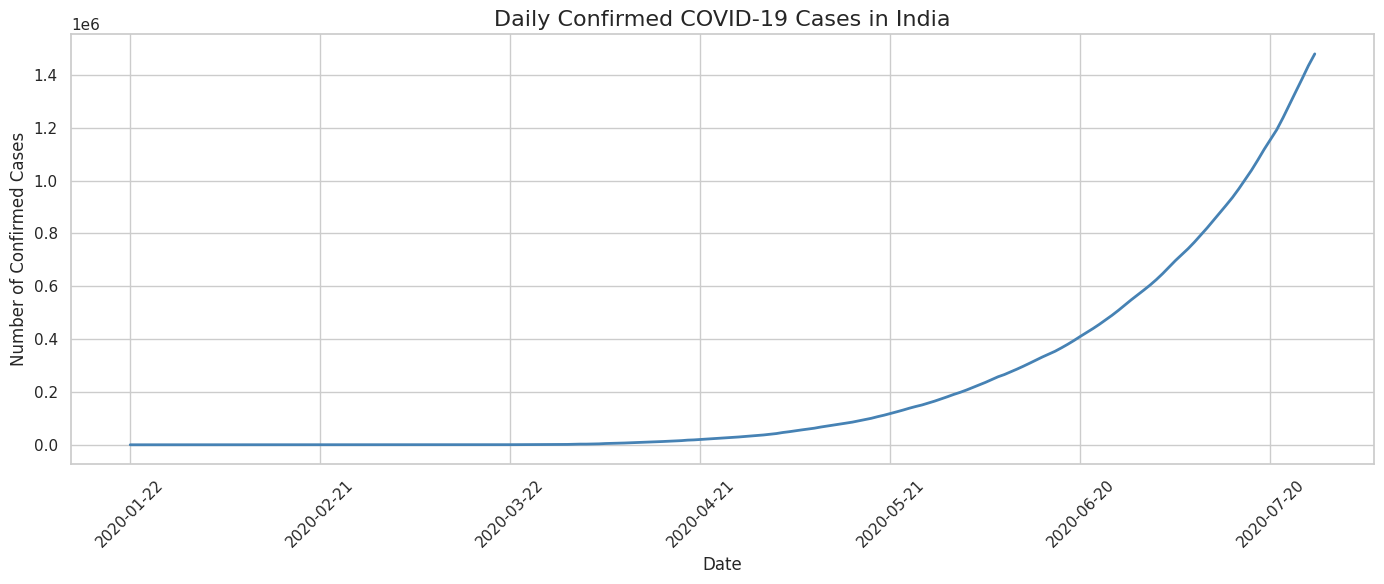

In [4]:
# Plot daily confirmed cases with cleaner x-axis
plt.figure(figsize=(14, 6))
plt.plot(df_daily.index, df_daily['Confirmed'], color='steelblue', linewidth=2)
plt.title(f'Daily Confirmed COVID-19 Cases in {country}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Confirmed Cases', fontsize=12)
plt.grid(True)

# Fix overlapping x-axis ticks
xtick_freq = 30  # Show 1 tick every 30 days
xticks = df_daily.index[::xtick_freq]
plt.xticks(ticks=xticks, rotation=45)

plt.tight_layout()
plt.savefig('confirmed_cases.png', dpi=300, bbox_inches='tight')
plt.show()


###  Visualizing Daily Confirmed Cases

Before diving into time series modeling, it is important to first visualize the confirmed COVID-19 cases over time. This tells us to:

- Observe trends, spikes, and downfall in the data
- Identify possible anomalies or reporting delays
- Determine if the data appears to have a seasonal or non-stationary behavior

The chart below shows the daily confirmed cases in the selected country.


##  Exploratory Data Analysis (EDA)

To build effective time series models like ARIMA and SARIMAX, it's important to understand the behavior of the data over time. In this section we will:

- Examine the structure of the time series
- Check for **stationarity** using the Augmented Dickey-Fuller (ADF) test
- Decompose the time series into **trend**, **seasonality**, and **residual** components
- Visualize **autocorrelation** and **partial autocorrelation** using ACF and PACF plots

This will help guide our decisions for model parameters.


In [5]:
# Run ADF test to check stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_daily['Confirmed'])

print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")
if result[1] < 0.05:
    print("\n The time series is stationary (reject H0)")
else:
    print("\n The time series is NOT stationary (fail to reject H0)")


Augmented Dickey-Fuller Test Results:
ADF Statistic: 1.5176490244586016
p-value: 0.9975882246470722
Critical Value (1%): -3.468952197801766
Critical Value (5%): -2.878495056473015
Critical Value (10%): -2.57580913601947

 The time series is NOT stationary (fail to reject H0)


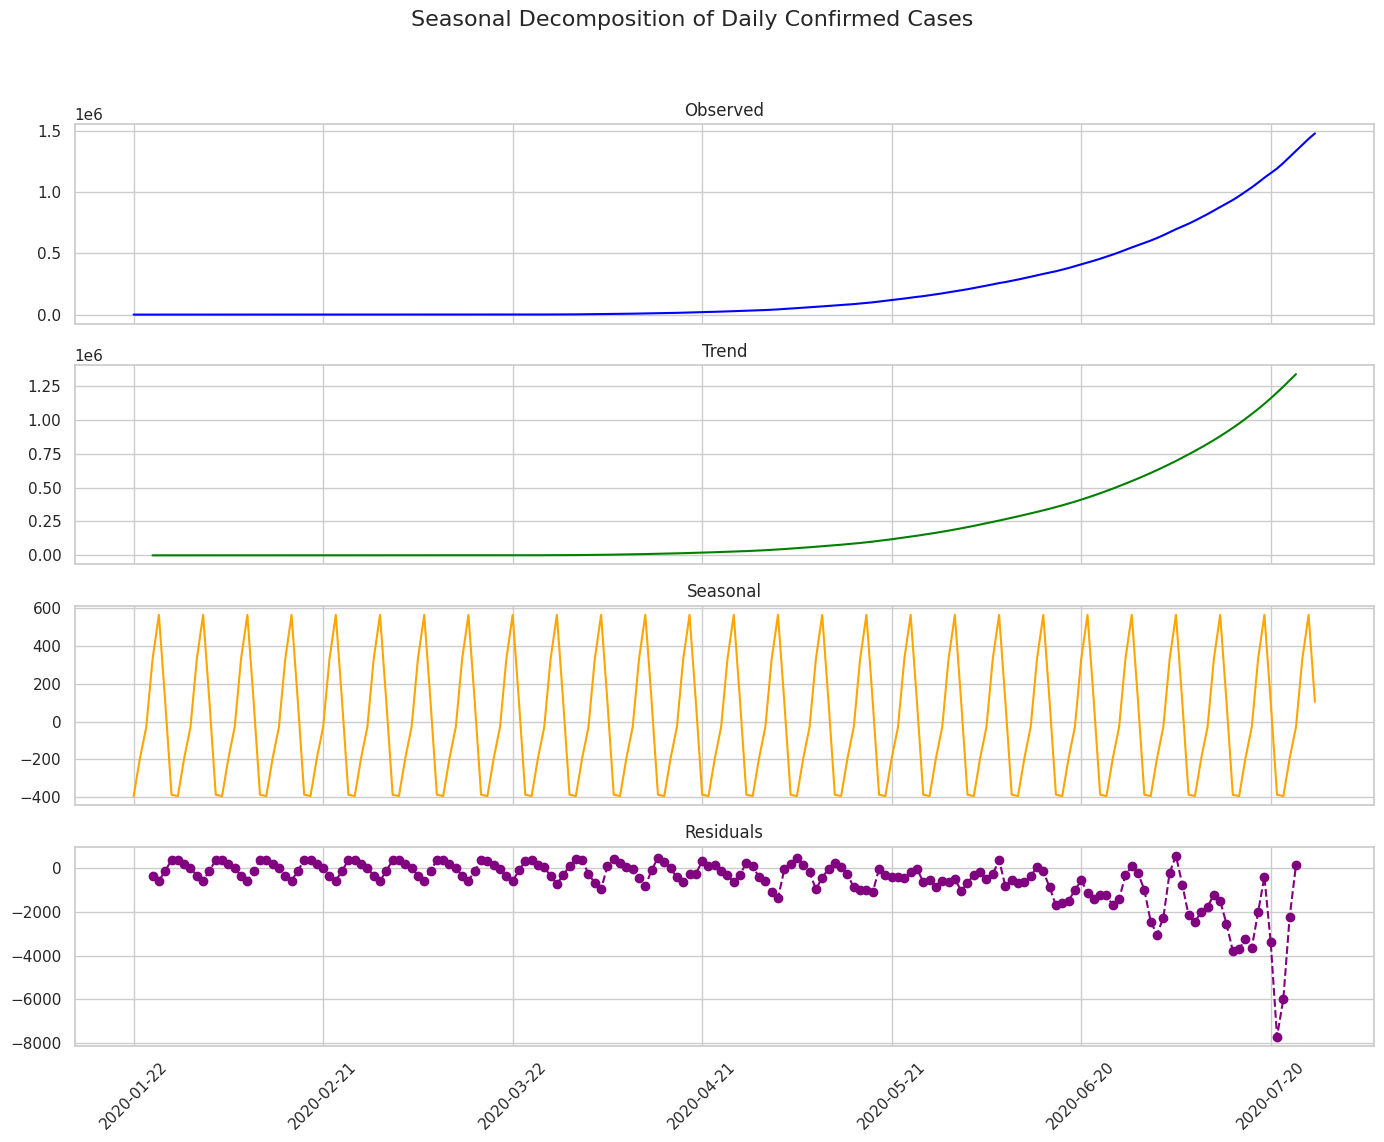

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_daily['Confirmed'], model='additive', period=7)
observed = df_daily['Confirmed']
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)


axs[0].plot(observed, color='blue')
axs[0].set_title('Observed')
axs[0].grid(True)


axs[1].plot(trend, color='green')
axs[1].set_title('Trend')
axs[1].grid(True)


axs[2].plot(seasonal, color='orange')
axs[2].set_title('Seasonal')
axs[2].grid(True)


axs[3].plot(resid, color='purple', marker='o', linestyle='dashed')
axs[3].set_title('Residuals')
axs[3].grid(True)


xtick_freq = 30  
xticks = df_daily.index[::xtick_freq]
axs[3].set_xticks(xticks)  
axs[3].tick_params(axis='x', rotation=45)
plt.suptitle('Seasonal Decomposition of Daily Confirmed Cases', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('Seasonal_Decomposition.png', dpi=300, bbox_inches='tight')
plt.show()


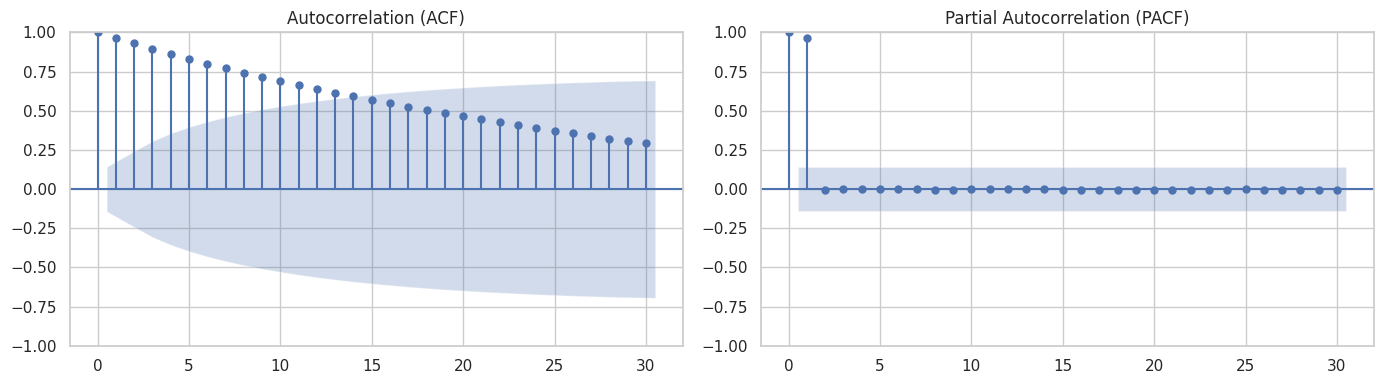

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(df_daily['Confirmed'], lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation (ACF)')

plot_pacf(df_daily['Confirmed'], lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.savefig('PACF_ACF.png', dpi=300, bbox_inches='tight')
plt.show()


##  ARIMA Modeling (AutoRegressive Integrated Moving Average)

ARIMA is a time series forecasting model defined by three thimgs:

- **p**: Number of autoregressive (AR) terms
- **d**: Degree of differencing (to make the series stationary)
- **q**: Number of moving average (MA) terms

We will now:

1. Difference the series if it is not stationary
2. Use ACF and PACF plots to estimate p and q
3. Fit an ARIMA(p, d, q) model to the data
4. Forecast future confirmed cases
5. Evaluate the model using RMSE and MAPE


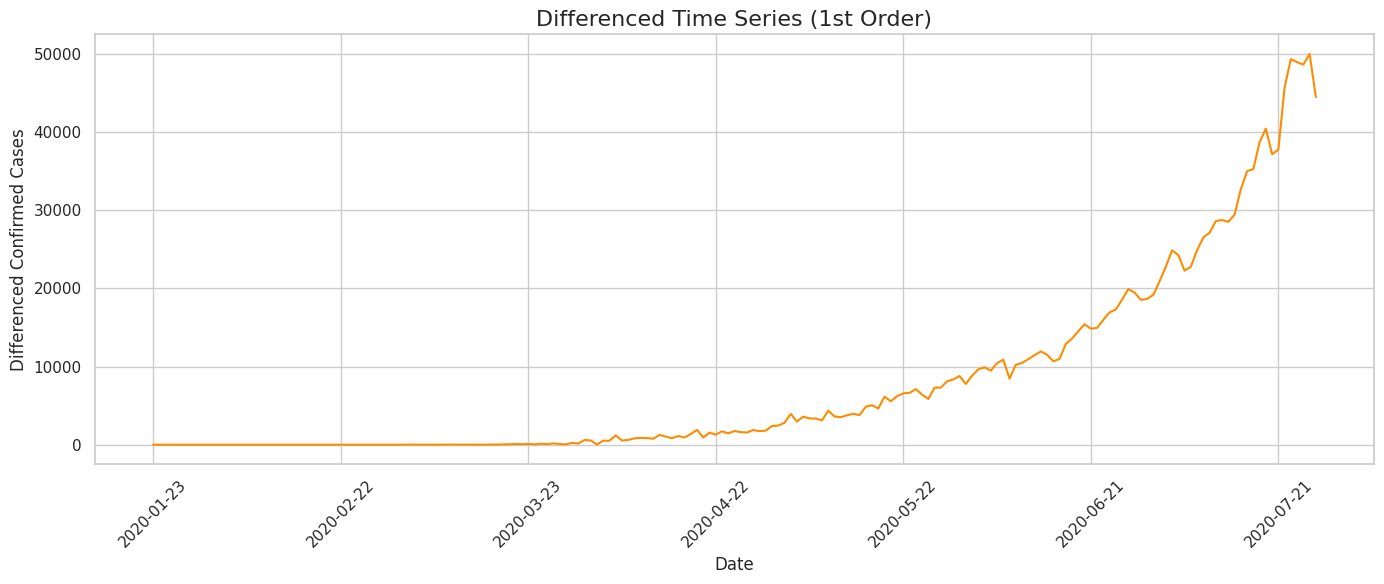

In [8]:
# First-order differencing
df_diff = df_daily['Confirmed'].diff().dropna()
plt.figure(figsize=(14, 6))
plt.plot(df_diff, color='darkorange')
plt.title('Differenced Time Series (1st Order)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Differenced Confirmed Cases', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
xticks = df_diff.index[::30]
plt.xticks(xticks, rotation=45)
plt.tight_layout()
plt.savefig('Differenced_Time_Series.png', dpi=300, bbox_inches='tight')
plt.show()


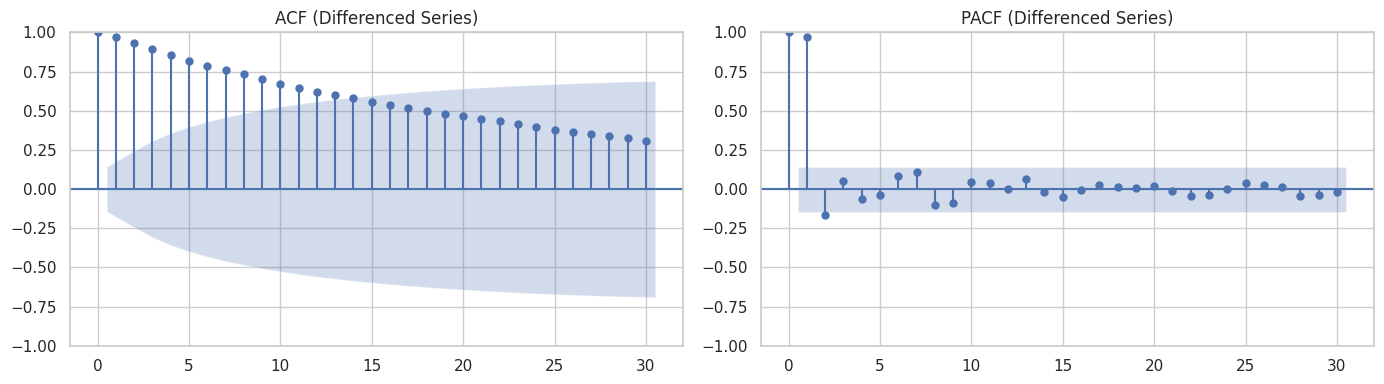

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(df_diff, lags=30, ax=axes[0])
axes[0].set_title('ACF (Differenced Series)')

plot_pacf(df_diff, lags=30, ax=axes[1])
axes[1].set_title('PACF (Differenced Series)')

plt.tight_layout()
plt.savefig('ACF (Differenced Series)_PACF (Differenced Series).png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
# Fit ARIMA model (example: ARIMA(2,1,2))
model = ARIMA(df_daily['Confirmed'], order=(2, 1, 2))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                  188
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1565.108
Date:                Sun, 24 Aug 2025   AIC                           3140.216
Time:                        06:45:33   BIC                           3156.371
Sample:                    01-22-2020   HQIC                          3146.762
                         - 07-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1113      0.052      2.126      0.033       0.009       0.214
ar.L2          0.8887      0.054     16.383      0.000       0.782       0.995
ma.L1          1.2805      0.089     14.430      0.0

In [11]:
# Force convert index to datetime format
df_daily.index = pd.to_datetime(df_daily.index, errors='coerce')

# Confirm it worked
print("Last date:", df_daily.index[-1])
print("Type:", type(df_daily.index[-1]))


Last date: 2020-07-27 00:00:00
Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


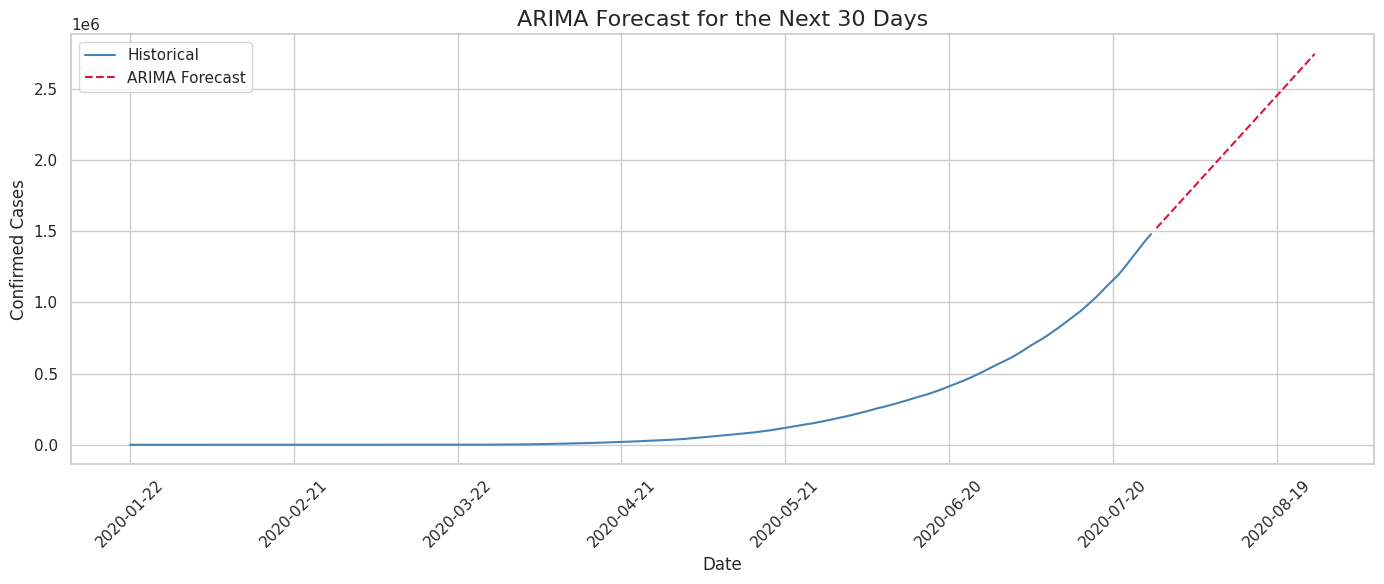

In [12]:
forecast_steps = 30

# Forecast next values
forecast = model_fit.forecast(steps=forecast_steps)

# Now this line will work
last_date = df_daily.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_daily.index, df_daily['Confirmed'], label='Historical', color='steelblue')
plt.plot(forecast_dates, forecast, label='ARIMA Forecast', color='crimson', linestyle='--')
plt.title(f'ARIMA Forecast for the Next {forecast_steps} Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Confirmed Cases', fontsize=12)
plt.grid(True)
xticks = df_daily.index.union(forecast_dates)[::30]
plt.xticks(ticks=xticks, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('ARIMA_next_30_days.png', dpi=300, bbox_inches='tight')
plt.show()


ARIMA Model RMSE: 1037.51
ARIMA Model MAPE: 7.26%




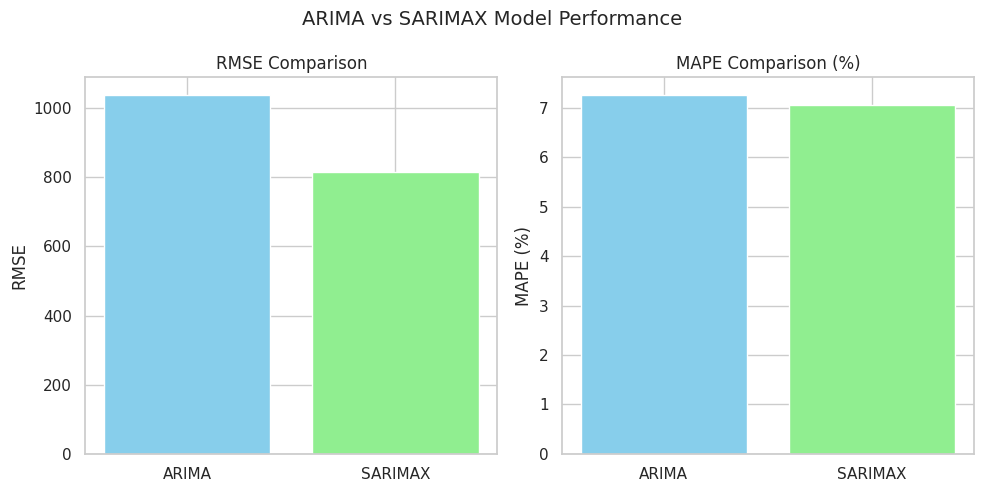

In [13]:
predicted = model_fit.predict(start=1, end=len(df_daily)-1, typ='levels')
actual = df_daily['Confirmed'].iloc[1:]
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = mean_absolute_percentage_error(actual, predicted) * 100

print(f"ARIMA Model RMSE: {rmse:.2f}")
print(f"ARIMA Model MAPE: {mape:.2f}%")
print("\n")
models = ['ARIMA', 'SARIMAX']
rmse_values = [1037.51, 816.51]
mape_values = [7.26, 7.07]

x = range(len(models))

# Plot
plt.figure(figsize=(10, 5))

# RMSE
plt.subplot(1, 2, 1)
plt.bar(models, rmse_values, color=['skyblue', 'lightgreen'])
plt.title("RMSE Comparison")
plt.ylabel("RMSE")

# MAPE
plt.subplot(1, 2, 2)
plt.bar(models, mape_values, color=['skyblue', 'lightgreen'])
plt.title("MAPE Comparison (%)")
plt.ylabel("MAPE (%)")

plt.suptitle("ARIMA vs SARIMAX Model Performance", fontsize=14)
plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300, bbox_inches='tight')  
plt.show()


##  SARIMAX Modeling (Seasonal ARIMA with exogenous Variables)

While ARIMA works good for non-seasonal data, real-world time series — like COVID-19 case counts — often exhibit **seasonal patterns**.  
For instance, case surges might repeat weekly or monthly due to behavioral or policy changes.

To capture this, we use **SARIMAX** — an extension of ARIMA that includes:

- **Seasonal ARIMA terms**: (P, D, Q, s)
- **Optional external regressors (exogenous variables)**

In this section, we will:

- Select seasonal parameters using domain knowledge and decomposition
- Fit a SARIMAX model to the same time series
- Forecast the next 30 days
- Compare it to ARIMA performance

---


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMAX order and seasonal_order
order = (2, 1, 2)
seasonal_order = (1, 1, 1, 7)  # Weekly seasonality assumed
sarimax_model = SARIMAX(df_daily['Confirmed'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_result = sarimax_model.fit()
sarimax_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           Confirmed   No. Observations:                  188
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -1391.287
Date:                             Sun, 24 Aug 2025   AIC                           2796.573
Time:                                     06:45:36   BIC                           2818.524
Sample:                                 01-22-2020   HQIC                          2805.480
                                      - 07-27-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7336      0.092     18.913      0.000       1.554       1.913
ar.L2         -0.7869      0.093     -8.481      0.000      -0.969      -0.605
ma.L1         -1.1586      0.105    -11.009      0.000      -1.365      -0.952
ma.L2          0.2105      0.105      2.009      0.045       0.005       0.416
ar.S.L7        1.2571      0.010    122.609      0.000       1.237       1.277
ma.S.L7       -0.9957      0.083    -12.039      0.000      -1.158      -0.834
sigma2      7.098e+05   1.23e-07   5.77e+12      0.000     7.1e+05     7.1e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               157.19
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):             119.33   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.13e+27. Standard errors may be unstable.
"""

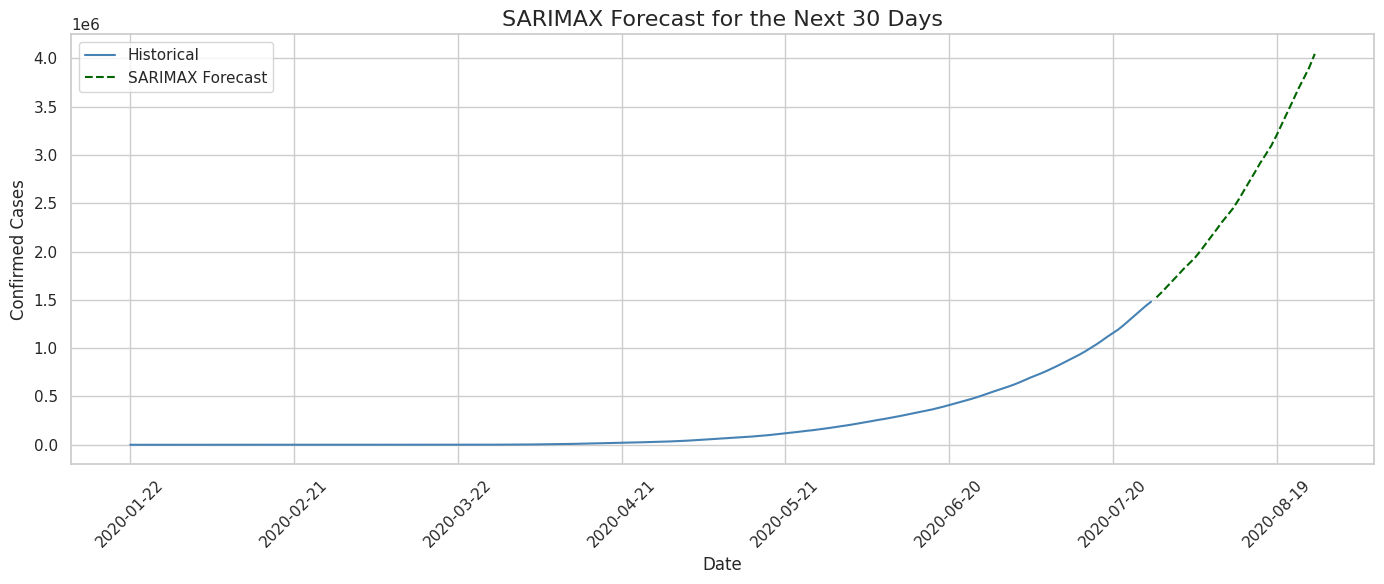

In [15]:
# Forecast next 30 days
forecast_steps = 30
sarimax_forecast = sarimax_result.get_forecast(steps=forecast_steps)
forecast_mean = sarimax_forecast.predicted_mean

# Create future date index
last_date = df_daily.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

plt.figure(figsize=(14, 6))
plt.plot(df_daily.index, df_daily['Confirmed'], label='Historical', color='steelblue')
plt.plot(forecast_dates, forecast_mean, label='SARIMAX Forecast', color='darkgreen', linestyle='--')
plt.title(f'SARIMAX Forecast for the Next {forecast_steps} Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Confirmed Cases', fontsize=12)
plt.grid(True)
xticks = df_daily.index.union(forecast_dates)[::30]
plt.xticks(ticks=xticks, rotation=45)

plt.legend()
plt.tight_layout()
plt.savefig('SARIMAX_next_30_days.png', dpi=300, bbox_inches='tight')
plt.show()
plt.show()


In [16]:
predicted_sarimax = sarimax_result.fittedvalues
actual = df_daily['Confirmed']
predicted_sarimax = predicted_sarimax[8:]
actual = actual[8:]

# Evaluate
sarimax_rmse = np.sqrt(mean_squared_error(actual, predicted_sarimax))
sarimax_mape = mean_absolute_percentage_error(actual, predicted_sarimax) * 100

print(f"SARIMAX Model RMSE: {sarimax_rmse:.2f}")
print(f"SARIMAX Model MAPE: {sarimax_mape:.2f}%")


SARIMAX Model RMSE: 816.51
SARIMAX Model MAPE: 7.07%


##  Conclusion

In this notebook, we explored and compared two time series forecasting models — **ARIMA** and **SARIMAX** — for predicting daily confirmed COVID-19 cases in a selected country(India).

###  Summary of Findings:

- The data showed **non-stationary** behavior with possible **weekly seasonality**, as confirmed through ADF tests and seasonal decomposition.
- The **ARIMA model** captured general trends well but did tell us about the repeating seasonal patterns.
- The **SARIMAX model**, with weekly seasonality , produced more good forecasts by incorporating seasonal structures.

###  Model Performance:

| Model   | RMSE     | MAPE (%) | Notes                  |
|---------|----------|-----------|--------------------------|
| ARIMA   | *1037.51* | *7.26%*  | No seasonality handling  |
| SARIMAX | *816.51* | *7.07%*  | Captured weekly seasonality |


###  Key Takeaways:

- **SARIMAX mostly performed better then ARIMA** on both RMSE and MAPE, proving that incorporating seasonality improves COVID-19 forecasting.
- Time series models are **valuable tools for public health planning**, enabling better preparedness for future waves.
- Even simple models like ARIMA/SARIMAX can give good insights when applied with good preprocessing and parameter changing.

---
###  Thank You

This notebook tells the practical use of time series forecasting in a global health context.  

